# Strain mapping with py4DSTEM

The code in this directory calculates and visualizes strain maps.

The procedure is divided into 7 steps, each in a single notebook.  This is notebook:
1. Get probe template
2. Get the Bragg disks
3. Determine the diffraction shifts
4. **Calculate lattice vectors**
5. Refine lattice vectors
6. Calculate strain
7. Visualize strain maps

# Notebook 4: Calculate lattice vectors

In this step the lattice vectors are calculated from the list of Bragg peaks, as follows:

* For one, typical diffraction pattern:
    * Get the list of Bragg peaks
    * Calculate the projection of the peak lists as a function of rotation, from 0 to 180 degrees
    * Find rotation angles that give the fewest, sharpest projected peaks
    * Get the lattice vectors
* Save the lattice vector list

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import RectBivariateSpline
from time import time
from skimage.transform import radon

from py4DSTEM.process.datastructure import PointList

In [2]:
# # Load the raw data
# fp = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.dm3"
# dc = py4DSTEM.readwrite.read_data(fp)
# dc.set_scan_shape(60,60)
# dc.data4D = np.roll(dc.data4D,-2,1) # Correct for acquisition wrap-around error

# # Load corrected Bragg peaks list
# fp_Braggpeaks = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/Bragg_disks__shift_corrected.h5"
# browser = py4DSTEM.readwrite.FileBrowser(fp_Braggpeaks)
# browser.show_dataobjects()
# Bragg_peaks = browser.get_dataobject(0)

# # Load the deconvolution
# fp_deconvolution = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/deconvolution.h5"
# browser = py4DSTEM.readwrite.FileBrowser(fp_deconvolution)
# browser.show_dataobjects()
# deconvolution = browser.get_dataobject(0)

In [88]:
# Load the raw data
fp = "/home/ben/Data/20180905_FePO4_unlithiated/raw/Stack1_57x47+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.dm4"
dc = py4DSTEM.readwrite.read_data(fp)
dc.set_scan_shape(47,57)
dc.data4D = np.roll(dc.data4D,-2,1) # Correct for acquisition wrap-around error

# Load corrected Bragg peaks list
fp_Braggpeaks = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Bragg_disks__shift_corrected.h5"
browser = py4DSTEM.readwrite.FileBrowser(fp_Braggpeaks)
browser.show_dataobjects()
Bragg_peaks = browser.get_dataobject(0)

# Load the deconvolution
fp_deconvolution = "/home/ben/Data/20180905_FePO4_unlithiated/processing/deconvolution.h5"
browser = py4DSTEM.readwrite.FileBrowser(fp_deconvolution)
browser.show_dataobjects()
deconvolution = browser.get_dataobject(0)

Reading file /home/ben/Data/20180905_FePO4_unlithiated/raw/Stack1_57x47+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.dm4...

/home/ben/Data/20180905_FePO4_unlithiated/raw/Stack1_57x47+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.dm4 is not a py4DSTEM file.  Reading with hyperspy...
 Index                  Name                        Type        
   0    shifted_Braggpeaks                  PointListArray      
 Index                  Name                        Type        
   0    diffractionslice_0                  DiffractionSlice    


### Take radon transform of average deconvolution

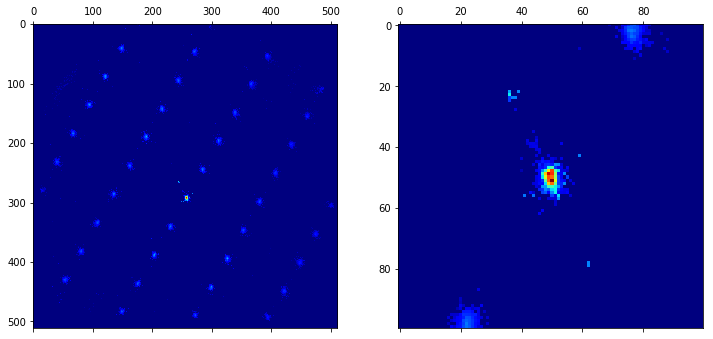

In [98]:
# Show deconvolution

power=0.25

x0,y0 = np.unravel_index(np.argmax(gaussian_filter(deconvolution.data2D,sigma=2)),(dc.Q_Nx,dc.Q_Ny))

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
ax1.matshow(deconvolution.data2D**power,cmap='jet')
ax2.matshow(deconvolution.data2D[x0-50:x0+50,y0-50:y0+50]**power,cmap='jet')
plt.show()

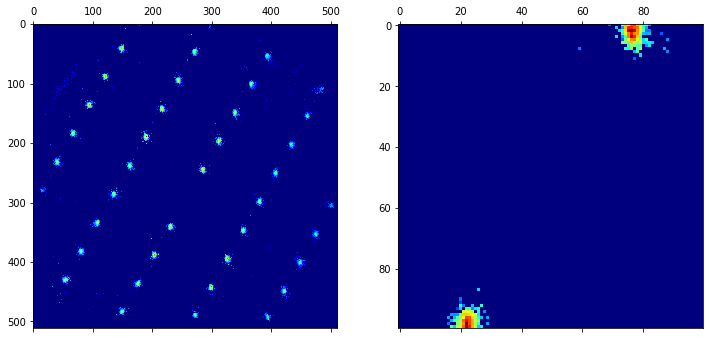

In [99]:
# Copy deconvolution and remove central beam from copy

maskrad = 40
power=0.25

deconvolution_beamstopped = np.copy(deconvolution.data2D)
x0,y0 = np.unravel_index(np.argmax(gaussian_filter(deconvolution.data2D,sigma=2)),(dc.Q_Nx,dc.Q_Ny))

ry,rx = np.meshgrid(np.arange(dc.Q_Ny),np.arange(dc.Q_Nx))
mask = ((rx-x0)**2+(ry-y0)**2) < maskrad**2
deconvolution_beamstopped[mask] = 0

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
ax1.matshow(deconvolution_beamstopped**power,cmap='jet')
ax2.matshow(deconvolution_beamstopped[x0-50:x0+50,y0-50:y0+50]**power,cmap='jet')
plt.show()

In [100]:
# Take Radon transform

N_thetas = 720
thetas = np.linspace(0,180,N_thetas)

sinogram = radon(deconvolution_beamstopped, theta=thetas, circle=False)

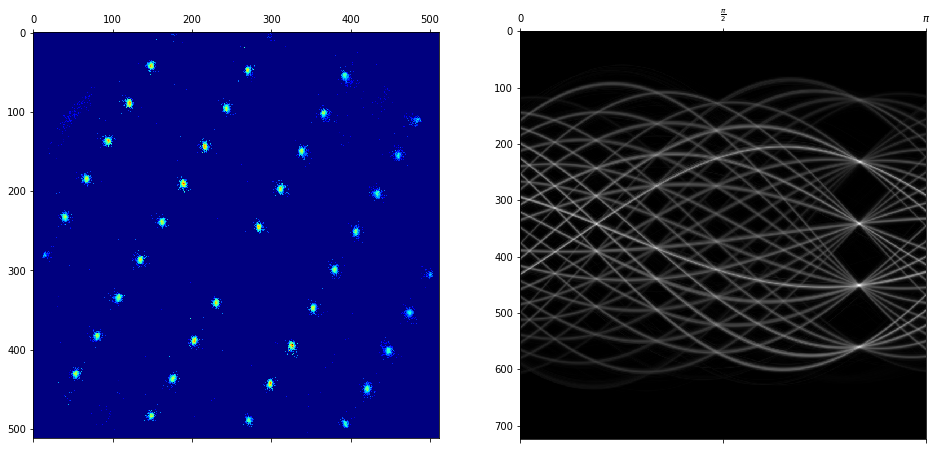

In [102]:
# Show

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
ax1.matshow(deconvolution_beamstopped**power,cmap='jet')
ax2.matshow(sinogram**0.5)
ax2.set_xticks([0,sinogram.shape[1]/2,sinogram.shape[1]])
ax2.set_xticklabels(['0',r'$\frac{\pi}{2}$',r'$\pi$'])
ax1.grid(False)
ax2.grid(False)
plt.show()

### For all angles, find maxima of Radon transform slice

In [104]:
# As a function of rotation angle, find number and intensity of histogram maxima

min_dist = 10
sigma = 2
threshhold = 0.05

# Metrics
N_maxima = np.empty_like(thetas)
total_intensity = np.empty_like(thetas)

for j in range(len(thetas)):
    theta = thetas[j]
    
    # Get slice through radon transform at theta
    ind = np.argmin(np.abs(thetas-theta))
    sinogram_theta = sinogram[:,ind]
    sinogram_theta = gaussian_filter(sinogram_theta,sigma)
    
    # Get maxima
    maxima0 = (sinogram_theta > np.roll(sinogram_theta,-1)) & (sinogram_theta >= np.roll(sinogram_theta,+1))
    
    coordinates = [('r',int),('intensity',float)]
    maxima = PointList(coordinates, dc)
    for i in maxima0.nonzero()[0]:
        new_point = (i, sinogram_theta[i])
        maxima.add_point(new_point)
    maxima.sort('intensity')

    # Remove maxima which are too close together
    deletemask = np.zeros(maxima.length,dtype=bool)
    for i in range(maxima.length):
        if not deletemask[i]:
            delete = np.abs(maxima.data['r'][i]-maxima.data['r']) < min_dist
            delete[:i+1]=False
            deletemask = deletemask | delete
    maxima.remove_points(deletemask)

    # Remove maxima below threshhold
    max_intensity = maxima.data['intensity'][0]
    deletemask = np.zeros(maxima.length,dtype=bool)
    for i in range(maxima.length):
        if maxima.data['intensity'][i]/max_intensity < threshhold:
            deletemask[i] = True
    maxima.remove_points(deletemask)
        
    # Calculat metrics
    N_maxima[j] = maxima.length
    total_intensity[j] = np.sum(maxima.data['intensity'])

### Get guess at u and v angles

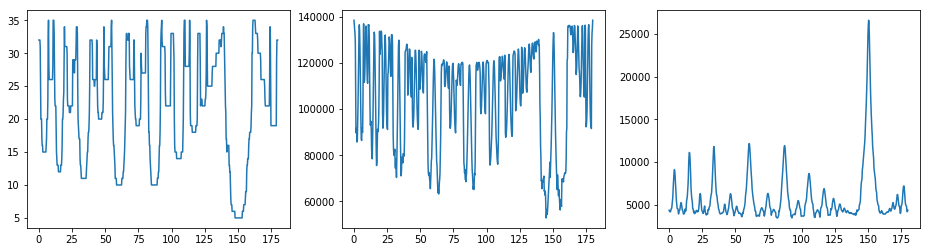

In [105]:
# Plot results. 
# Number of maxima, total intensity of maxima, and score (inten/#) function

score = total_intensity/N_maxima

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(16,4))
ax1.plot(thetas,N_maxima)
ax2.plot(thetas,total_intensity)
ax3.plot(thetas,score)
plt.show()

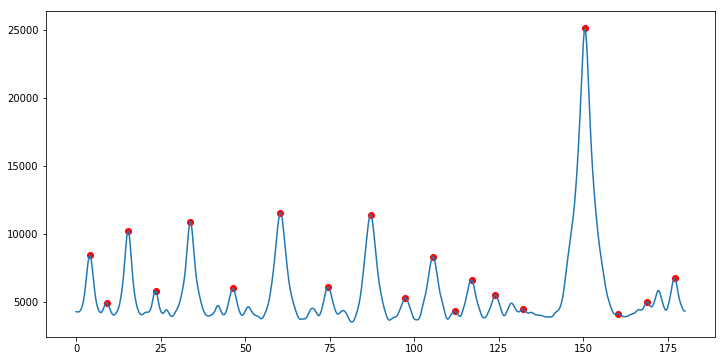

In [106]:
# Get maxima of scores

sigma = 2
min_diff = 5

score_blurred = gaussian_filter(score,sigma)

score_maxima0 = (score_blurred > np.roll(score_blurred,-1)) & (score_blurred >= np.roll(score_blurred,+1))

coordinates = [('theta',float),('intensity',float)]
score_maxima = PointList(coordinates, dc)

for i in score_maxima0.nonzero()[0]:
    new_point = (thetas[i], score_blurred[i])
    score_maxima.add_point(new_point)
score_maxima.sort('intensity')

deletemask = np.zeros(score_maxima.length,dtype=bool)
for i in range(score_maxima.length):
    if not deletemask[i]:
        delete = np.abs(score_maxima.data['theta'][i]-score_maxima.data['theta']) < min_diff
        delete[:i+1]=False
        deletemask = deletemask | delete
score_maxima.remove_points(deletemask)


# Plot score and maxima

fig,ax = plt.subplots(figsize=(12,6))
ax.plot(thetas, score_blurred)
ax.scatter(score_maxima.data['theta'],score_maxima.data['intensity'],color='r')
plt.show()

In [107]:
# Get initial guess at u angle

score_maxima.sort('intensity')
u_theta = score_maxima.data['theta'][0]

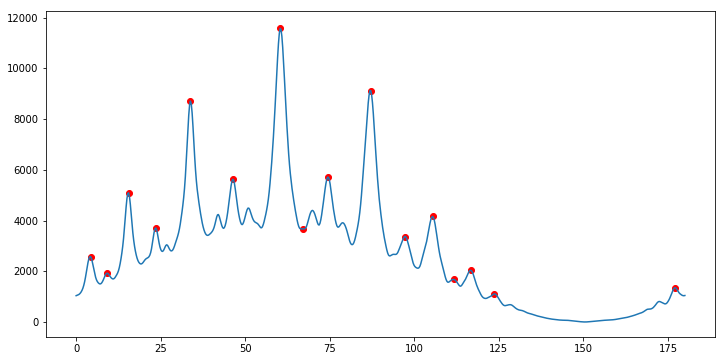

In [108]:
# Damp scores by cosine envelope about the u angle
# Get maxima, plot

sigma = 2
min_diff = 5

score_sin_damped = score_blurred*np.sin((thetas-u_angle0)*np.pi/180.)**2

score_maxima0 = (score_sin_damped > np.roll(score_sin_damped,-1)) & (score_sin_damped >= np.roll(score_sin_damped,+1))

coordinates = [('theta',float),('intensity',float)]
score_maxima = PointList(coordinates, dc)

for i in score_maxima0.nonzero()[0]:
    new_point = (thetas[i], score_sin_damped[i])
    score_maxima.add_point(new_point)
score_maxima.sort('intensity')

deletemask = np.zeros(score_maxima.length,dtype=bool)
for i in range(score_maxima.length):
    if not deletemask[i]:
        delete = np.abs(score_maxima.data['theta'][i]-score_maxima.data['theta']) < min_diff
        delete[:i+1]=False
        deletemask = deletemask | delete
score_maxima.remove_points(deletemask)

# Plot
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(thetas, score_sin_damped)
ax.scatter(score_maxima.data['theta'],score_maxima.data['intensity'],color='r')
plt.show()

In [109]:
# Get guess at v angle

score_maxima.sort('intensity')
v_theta = score_maxima.data['theta'][0]

In [110]:
print("Initial guess at u and v angles is {} and {}, respectively.".format(u_theta,v_theta))

Initial guess at u and v angles is 150.45897079276773 and 60.333796940194716, respectively.


### Get lattice vector lengths

In [111]:
# Parameters

sigma = 2
min_dist = 10
threshhold = 0.05

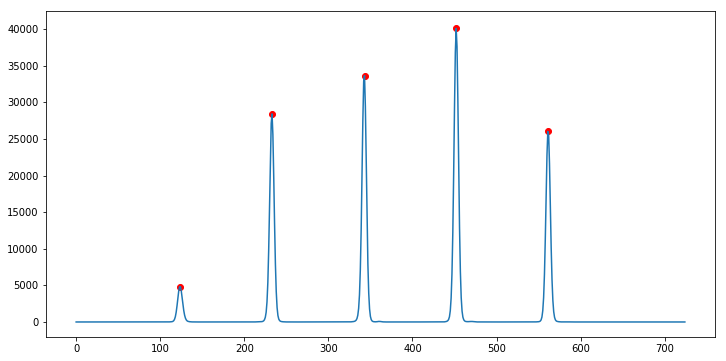

In [112]:
# Find maxima when projected down u

theta = u_theta

# Get slice through radon transform at theta
ind = np.argmin(np.abs(thetas-theta))
sinogram_theta = sinogram[:,ind]
sinogram_theta = gaussian_filter(sinogram_theta,sigma)

# Get maxima
maxima0 = (sinogram_theta > np.roll(sinogram_theta,-1)) & (sinogram_theta >= np.roll(sinogram_theta,+1))

coordinates = [('r',int),('intensity',float)]
maxima = PointList(coordinates, dc)
for i in maxima0.nonzero()[0]:
    new_point = (i, sinogram_theta[i])
    maxima.add_point(new_point)
maxima.sort('intensity')

# Remove maxima which are too close together
deletemask = np.zeros(maxima.length,dtype=bool)
for i in range(maxima.length):
    if not deletemask[i]:
        delete = np.abs(maxima.data['r'][i]-maxima.data['r']) < min_dist
        delete[:i+1]=False
        deletemask = deletemask | delete
maxima.remove_points(deletemask)

# Remove maxima below threshhold
max_intensity = maxima.data['intensity'][0]
deletemask = np.zeros(maxima.length,dtype=bool)
for i in range(maxima.length):
    if maxima.data['intensity'][i]/max_intensity < threshhold:
        deletemask[i] = True
maxima.remove_points(deletemask)

# Plot
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(np.arange(sinogram_theta.shape[0]), sinogram_theta)
ax.scatter(maxima.data['r'],maxima.data['intensity'],color='r')
plt.show()

In [113]:
# Get u projected spacing

thresh=1.5

maxima.sort('r')
diffs = maxima.data['r'][:-1]-maxima.data['r'][1:]
mask = np.array([max(i,np.median(diffs))/min(i,np.median(diffs)) for i in diffs]) < thresh
diffs = diffs[mask]
u_projected_spacing = np.average(diffs)

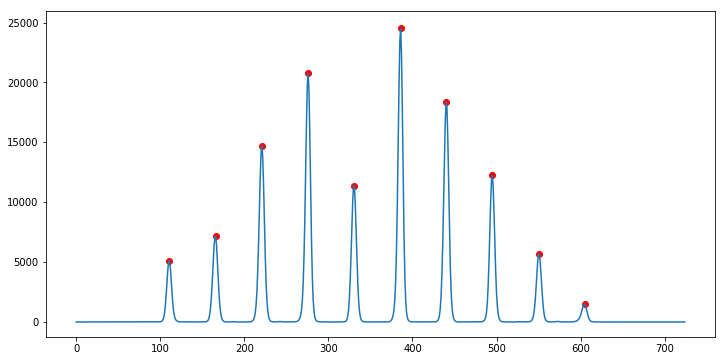

In [114]:
# Find maxima when projected down v

theta = v_theta

# Get slice through radon transform at theta
ind = np.argmin(np.abs(thetas-theta))
sinogram_theta = sinogram[:,ind]
sinogram_theta = gaussian_filter(sinogram_theta,sigma)

# Get maxima
maxima0 = (sinogram_theta > np.roll(sinogram_theta,-1)) & (sinogram_theta >= np.roll(sinogram_theta,+1))

coordinates = [('r',int),('intensity',float)]
maxima = PointList(coordinates, dc)
for i in maxima0.nonzero()[0]:
    new_point = (i, sinogram_theta[i])
    maxima.add_point(new_point)
maxima.sort('intensity')

# Remove maxima which are too close together
deletemask = np.zeros(maxima.length,dtype=bool)
for i in range(maxima.length):
    if not deletemask[i]:
        delete = np.abs(maxima.data['r'][i]-maxima.data['r']) < min_dist
        delete[:i+1]=False
        deletemask = deletemask | delete
maxima.remove_points(deletemask)

# Remove maxima below threshhold
max_intensity = maxima.data['intensity'][0]
deletemask = np.zeros(maxima.length,dtype=bool)
for i in range(maxima.length):
    if maxima.data['intensity'][i]/max_intensity < threshhold:
        deletemask[i] = True
maxima.remove_points(deletemask)

# Plot
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(np.arange(sinogram_theta.shape[0]), sinogram_theta)
ax.scatter(maxima.data['r'],maxima.data['intensity'],color='r')
plt.show()

In [115]:
# Get v projected spacing

thresh=1.5

maxima.sort('r')
diffs = maxima.data['r'][:-1]-maxima.data['r'][1:]
mask = np.array([max(i,np.median(diffs))/min(i,np.median(diffs)) for i in diffs]) < thresh
diffs = diffs[mask]
v_projected_spacing = np.average(diffs)

In [116]:
# Get u and v lengths

sin_uv = np.sin(np.abs(u_theta-v_theta)*np.pi/180.)
u_length = v_projected_spacing / sin_uv
v_length = u_projected_spacing / sin_uv

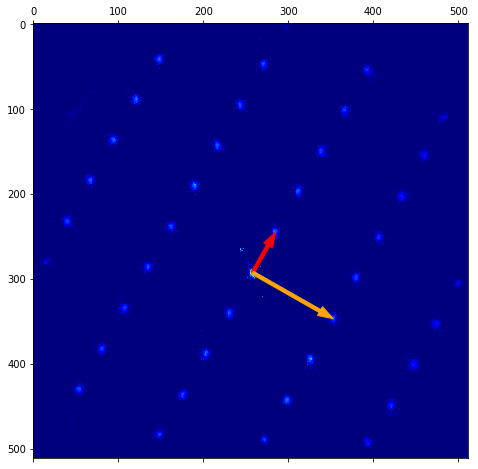

In [127]:
# Show

power = 0.25

x0,y0 = np.unravel_index(np.argmax(gaussian_filter(deconvolution.data2D,sigma=2)),(dc.Q_Nx,dc.Q_Ny))

u_dx = np.sin(u_theta*np.pi/180.)*u_length
u_dy = np.cos(u_theta*np.pi/180.)*u_length
v_dx = np.sin(v_theta*np.pi/180.)*v_length
v_dy = np.cos(v_theta*np.pi/180.)*v_length

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(deconvolution.data2D**power,cmap='jet')
ax.arrow(y0,x0,u_dx,u_dy, color='red',width=4,length_includes_head=True)
ax.arrow(y0,x0,v_dx,v_dy, color='orange',width=4,length_includes_head=True)
plt.show()

### Save lattice vectors

In [129]:
# Make pointlist

coordinates = [('angle',float),('length',float)]
lattice_vectors = PointList(coordinates, dc, name='lattice_vectors')
lattice_vectors.add_point((u_theta,u_length))
lattice_vectors.add_point((v_theta,v_length))

In [130]:
# Save

savepath = "/home/ben/Data/20180905_FePO4_unlithiated/processing/lattice_vectors.h5"
py4DSTEM.readwrite.save_dataobject(lattice_vectors,savepath)

Creating file /home/ben/Data/20180905_FePO4_unlithiated/processing/lattice_vectors.h5...
Writing metadata...
Done.


In [39]:
# Save

savepath = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/lattice_vectors.h5"
py4DSTEM.readwrite.save_dataobject(lattice_vectors,savepath)